## Implementation of Actor-Critic Reinforcement Learning Model for LunarLander-v2

## conda install -c conda-forge gym-box2d

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

Episode 5: Reward = -327.225445575533
Evaluation Episode 1: Reward = -170.56203548916616
Evaluation Episode 2: Reward = -166.61386200552795
Evaluation Episode 3: Reward = -96.62956544518613
Evaluation Episode 4: Reward = -145.7910971750644
Evaluation Episode 5: Reward = -384.81985044080795
Evaluation Episode 6: Reward = -101.22138993357672
Evaluation Episode 7: Reward = -129.08430694508868
Evaluation Episode 8: Reward = -134.97412838730827
Evaluation Episode 9: Reward = -141.10438228990358
Evaluation Episode 10: Reward = -145.45796990015594
Evaluation Episode 11: Reward = -145.3585701475796
Evaluation Episode 12: Reward = -146.17172230678108
Evaluation Episode 13: Reward = -148.3748779612633
Evaluation Episode 14: Reward = -123.8359022978723
Evaluation Episode 15: Reward = -154.17197319134505
Evaluation Episode 16: Reward = -278.7868561661061
Evaluation Episode 17: Reward = 2.69380229271556
Evaluation Episode 18: Reward = -144.04521702988052
Evaluation Episode 19: Reward = -160.2550061

Random Policy Evaluation Episode 64: Reward = -116.45827484354756
Random Policy Evaluation Episode 65: Reward = -112.59342166857658
Random Policy Evaluation Episode 66: Reward = -115.53581231700309
Random Policy Evaluation Episode 67: Reward = -141.54290248219542
Random Policy Evaluation Episode 68: Reward = -447.7612378619749
Random Policy Evaluation Episode 69: Reward = -115.4731075416758
Random Policy Evaluation Episode 70: Reward = -486.9106348286718
Random Policy Evaluation Episode 71: Reward = -381.5675473268767
Random Policy Evaluation Episode 72: Reward = -146.4725518571467
Random Policy Evaluation Episode 73: Reward = -40.926291006130526
Random Policy Evaluation Episode 74: Reward = -274.52461206924545
Random Policy Evaluation Episode 75: Reward = -144.72817480200803
Random Policy Evaluation Episode 76: Reward = -114.84864920831505
Random Policy Evaluation Episode 77: Reward = -167.82327397867894
Random Policy Evaluation Episode 78: Reward = -228.13003455655937
Random Policy E

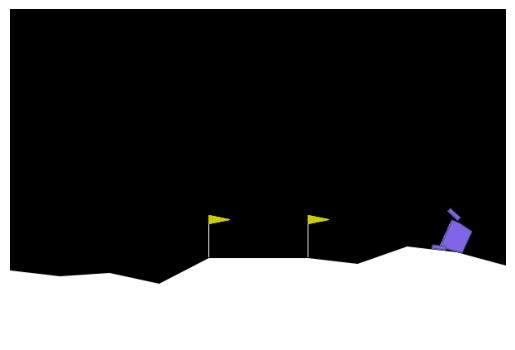

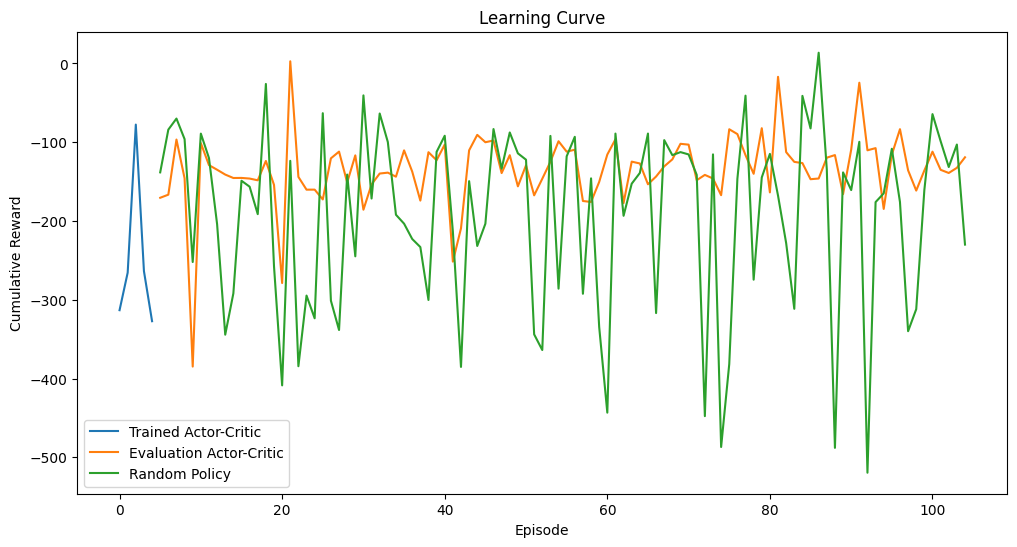

In [6]:
# Actor network definition
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_probs = torch.softmax(self.fc3(x), dim=-1)
        return action_probs

# Critic network definition
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.fc3(x)
        return value

# Set up the environment
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Dimensions of state and action spaces
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Instantiate the actor and critic networks
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)

# Define the optimizers for actor and critic networks
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

def render_env(env):
    img = env.render()
    plt.imshow(img)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)

def train_actor_critic(env, actor, critic, actor_optimizer, critic_optimizer, num_episodes=5, gamma=0.99):
    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        episode_reward = 0

        while not done:
            # Render the environment
            render_env(env)
            
            # Get action probabilities from actor network
            action_probs = actor(state)
            dist = Categorical(action_probs)
            action = dist.sample()

            # Take the action in the environment
            next_state, reward, done, info, _ = env.step(action.item())
            next_state = torch.tensor(next_state, dtype=torch.float32)
            episode_reward += reward

            # Compute the value of the current state and next state
            value = critic(state)
            next_value = critic(next_state)

            # Compute the advantage
            target = reward + (1 - done) * gamma * next_value
            advantage = target - value

            # Update critic network
            critic_loss = advantage.pow(2).mean()
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Update actor network
            actor_loss = -(dist.log_prob(action) * advantage.detach()).mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # Move to the next state
            state = next_state
        
        rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    return rewards

# Train the model
train_rewards = train_actor_critic(env, actor, critic, actor_optimizer, critic_optimizer)

# Evaluation functions
def evaluate(env, actor, num_episodes=100):
    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        episode_reward = 0

        while not done:
            action_probs = actor(state)
            dist = Categorical(action_probs)
            action = dist.sample()
            next_state, reward, done, info, _ = env.step(action.item())
            next_state = torch.tensor(next_state, dtype=torch.float32)
            episode_reward += reward
            state = next_state
        
        rewards.append(episode_reward)
        print(f"Evaluation Episode {episode + 1}: Reward = {episode_reward}")
    
    return rewards

def evaluate_random_policy(env, num_episodes=100):
    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = env.action_space.sample()
            next_state, reward, done, info, _ = env.step(action)
            episode_reward += reward
            state = next_state
        
        rewards.append(episode_reward)
        print(f"Random Policy Evaluation Episode {episode + 1}: Reward = {episode_reward}")
    
    return rewards

# Evaluate the trained model
trained_rewards = evaluate(env, actor)

# Evaluate the random policy
random_rewards = evaluate_random_policy(env)

# Plotting the learning curve
plt.figure(figsize=(12, 6))
plt.plot(train_rewards, label='Trained Actor-Critic')
plt.plot(range(len(train_rewards), len(train_rewards) + len(trained_rewards)), trained_rewards, label='Evaluation Actor-Critic')
plt.plot(range(len(train_rewards), len(train_rewards) + len(random_rewards)), random_rewards, label='Random Policy')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curve')
plt.legend()
plt.show()


Rendering during training: The environment is rendered every 10 episodes (adjustable with render_interval).
Rendering during evaluation: The environment is rendered in every episode during evaluation to visualize the agent's performance.